# Analysis superficial layer (Dave's arch mice)

In [1]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

In [2]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import pandas as pd
import h5py

pd.options.mode.chained_assignment = None  # default='warn'

from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
from IPython.display import display, HTML

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general


In [3]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


In [4]:
# load the parameters to connect to data_1 
params = config()

## Analysis

Retrieve stimulus table for Dave's arch mice

In [5]:
inhib_p_thresh = .001 # arbitrary at the moment!

In [6]:
%%time
params = config()
unique = "(cluster_no, tetrode_no, session_name, n_drive_user, animal_id, session_ts)"

sql = "SELECT stimulus_tb.*, stimulus_mat_tb.spiketimes_cluster, stimulus_mat_tb.stimulus_timepoints,stimulus_mat_tb.sum_1ms,  \
        stimulus_mat_tb.bin_edges_1ms, stimulus_mat_tb.binnumber_1ms \
        FROM stimulus_tb INNER JOIN stimulus_mat_tb USING {} \
        WHERE inhibited = True AND stimulus_tb.inhib_lowest_p != 'nan'  \
        AND (stimulus_tb.animal_id LIKE '%T%' OR stimulus_tb.animal_id = '70113' OR stimulus_tb.animal_id = '70110' OR \
        stimulus_tb.animal_id = '70114') AND \
        stimulus_tb.change_point_ms < 10 AND stimulus_tb.inhib_lowest_p_interval > 10 \
        \
        ORDER BY inhib_lowest_p ASC;".format(unique)
sql_db_pd = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
print('{} entries found'.format(len(sql_db_pd)))

175 entries found
Wall time: 20 s


In [7]:
# if you want to save
export_path_pickle  = r"C:\work\python\klusta_analysis\postgres_notebooks\export_dataframes"
export_path_pickle = "/".join(export_path_pickle.split("\\"))
sql_db_pd.to_pickle(export_path_pickle + "/all_sup_layer_stimulus.pkl")

In [8]:
sup_layer_exc_inhib_df = pd.read_pickle(export_path_pickle + "/all_sup_layer_stimulus.pkl")

In [9]:
len(sup_layer_exc_inhib_df)

175

In [10]:
#subsets
sup_layer_inhib = sup_layer_exc_inhib_df[(sup_layer_exc_inhib_df.inhib_lowest_p < inhib_p_thresh) & 
                                          (sup_layer_exc_inhib_df.inhibited == True)]

sup_layer_rest = sup_layer_exc_inhib_df.iloc[[x for x in sup_layer_exc_inhib_df.index if (x not in sup_layer_inhib.index)]]

In [11]:
# sort dataframe inhibited:
sup_layer_inhib.sort_values('inhib_lowest_p',ascending=True, inplace=True)

In [12]:
# groupby (to count occurences = number of sessions that met threshold criterion)
sup_layer_inhib_count = sup_layer_inhib.groupby(['session_ts','animal_id','tetrode_no','cluster_no']).count()

# and reset index
sup_layer_inhib_count.reset_index(inplace=True)

In [13]:
# drop duplicates (maintaining the most significant / highest I session)
sup_layer_inhib.drop_duplicates(subset=['session_ts','animal_id','tetrode_no','cluster_no'],inplace=True)
sup_layer_rest.drop_duplicates(subset=['session_ts','animal_id','tetrode_no','cluster_no'],inplace=True)

In [14]:
# reset indices
sup_layer_inhib.reset_index(drop=True,inplace=True)
sup_layer_rest.reset_index(drop=True,inplace=True)

In [15]:
# update columns excited / inhibited
sup_layer_inhib['inhibited'] = (sup_layer_inhib.inhib_lowest_p < inhib_p_thresh) & (sup_layer_inhib.inhibited == True)
sup_layer_rest['inhibited'] = (sup_layer_rest.inhib_lowest_p < inhib_p_thresh) & (sup_layer_rest.inhibited == True)

### Retrieve additional entries from other tables to filter on

In [16]:
isi_stats_cells =  pd.DataFrame()

# Retrieve only data from sup_layer_inhib

for df in tqdm_notebook([sup_layer_inhib]):
    for i in tqdm_notebook(xrange(len(df))):
        c_entry = df.iloc[i]
            
        # isi stats (base session)
        sql = "SELECT ISI_stats_contam, ISI_stats_contam_perc, ISI_stats_percent_bursts FROM ISI_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,
                                                               c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['isi_stats_contam','isi_stats_contam_perc',
                                                 'isi_stats_percent_bursts']]],axis=1) # horizontally join the two entries
            isi_stats_cells = pd.concat([isi_stats_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['isi_stats_contam'],c_entry_T['isi_stats_contam_perc'],c_entry_T['isi_stats_percent_bursts'] = np.nan,np.nan,np.nan
            isi_stats_cells = pd.concat([isi_stats_cells,  c_entry_T], axis=0) # vertically join it with the rest   
            
print('Finished.')


Finished.


#### Right now you have:

- isi_stats_cells (on sup_layer_inhib)
- sup_layer_inhib

**Employ additional filtering criteria**: 
- *Generally*: include only cells with ISI contam < 1%
- For inhibited cells include only cells whose most significant p interval (!) > 10 ms
    - (later check for these inhibited cells, whether the p-value becomes insignificant at 40 ms (indicating short inhibition))

- then also look up BNT scores, autocorr scores and ISI_burst score (after all that filtering and for every dataset)

In [17]:
isi_cutoff = 1 # %

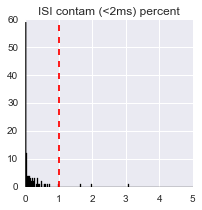

In [18]:
# seek justification for arbitrary threshold ;) 
sns.set_style('darkgrid')
figure = plt.figure(figsize=(3,3))
isi_stats_cells.isi_stats_contam_perc.hist(bins=500, color='k')
plt.xlim(0,5)
plt.axvline(x=isi_cutoff,color='red',linestyle='--')
plt.title('ISI contam (<2ms) percent')
sns.despine()

In [19]:
# Before filtering, these cell numbers remain at the moment: 
print('Total before filtering: {}'.format(len(sup_layer_inhib)))

Total before filtering: 121


##### ... for inhibited cells

In [20]:
# go through inhibited cells and employ filter criteria: 
indices_to_keep = []
offset = 0
for no in tqdm_notebook(xrange(len(sup_layer_inhib))):
    if isi_stats_cells.isi_stats_contam_perc.values[no+offset] < isi_cutoff:
                if sup_layer_inhib.inhib_lowest_p_interval.iloc[no] > 10: # don't need this strictly because it's already there before!
                    indices_to_keep.append(no)
print('{} clusters remaining from inhibited cells.'.format(len(indices_to_keep)))


114 clusters remaining from inhibited cells.


In [21]:
sup_layer_inhib_filtered = sup_layer_inhib.iloc[indices_to_keep]

**Now you have filtered datasets for**
- sup_layer_inhib_filtered (filtered for good ISI and lowest p interval > 10ms)

Careful: Isi_stats are not filtered! 

### Retrieve rest of useful information to plot

##### Retrieve data from the same TETRODE!! (omit cluster_no search string)

In [22]:
autocorr_cells = pd.DataFrame()
#ratemaps_cells = pd.DataFrame()
#obj_ratemaps_cells = pd.DataFrame()
bnt_scores_cells = pd.DataFrame()

#spiketimes_tracking_cells = pd.DataFrame()
#obj_spiketimes_tracking_cells = pd.DataFrame()

# TAKE ONLY THE INHIBITED DATASET

for df in tqdm_notebook([sup_layer_inhib_filtered]):
    for i in tqdm_notebook(xrange(len(df))):
        c_entry = df.iloc[i]

        # retrieve the base session stats:
        # autocorr (st_autocorr_tb):
        sql = "SELECT theta_idx, burst_idx1, burst_idx2 FROM st_autocorr_tb \
              WHERE animal_id = '{}' AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: 
            for ent in xrange(len(c_sql)):
                c_entry_T = pd.DataFrame(c_entry).T
                c_entry_T.reset_index(inplace=True,drop=True)
                for feat in ['theta_idx','burst_idx1','burst_idx2']:
                    c_entry_T[feat] = c_sql.iloc[ent][feat]
                autocorr_cells = pd.concat([autocorr_cells,  c_entry_T], axis=0) # vertically join it with the rest    
        if len(c_sql) == 1: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['theta_idx','burst_idx1','burst_idx2']]],axis=1) # horizontally join the two entries
            autocorr_cells = pd.concat([autocorr_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['theta_idx'],c_entry_T['burst_idx1'],c_entry_T['burst_idx2'] = np.nan,np.nan,np.nan
            autocorr_cells = pd.concat([autocorr_cells,  c_entry_T], axis=0) # vertically join it with the rest         
        
        
#        # ratemaps (ratemaps_tb):
#        sql = "SELECT masked_ratemap FROM ratemaps_tb \
#              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
#              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
#              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)
#
#        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
#        if len(c_sql) > 1: sys.exit()
#        if len(c_sql) != 0: 
#            # concat the new with the old dataframe:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            c_join = pd.concat([c_entry_T,c_sql[['masked_ratemap']]],axis=1) # horizontally join the two entries
#            ratemaps_cells = pd.concat([ratemaps_cells,  c_join], axis=0) # vertically join it with the rest
#        else:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            fake_map = fake_ratemap()
#            c_entry_T['fake_ratemap'] = [np.array(fake_map)]
#            ratemaps_cells = pd.concat([ratemaps_cells,  c_entry_T], axis=0) # vertically join it with the rest
#               
#                
#        # object ratemaps (ratemaps_tb):
#        sql = "SELECT masked_ratemap FROM ratemaps_tb \
#              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
#              session_ts = '{}' AND \
#              session_name LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)
#
#        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
#        if len(c_sql) > 1: sys.exit()
#        if len(c_sql) != 0: 
#            # concat the new with the old dataframe:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            c_join = pd.concat([c_entry_T,c_sql[['masked_ratemap']]],axis=1) # horizontally join the two entries
#            obj_ratemaps_cells = pd.concat([obj_ratemaps_cells,  c_join], axis=0) # vertically join it with the rest
#        else:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            fake_map = fake_ratemap()
#            c_entry_T['fake_ratemap'] = [np.array(fake_map)]
#            obj_ratemaps_cells = pd.concat([obj_ratemaps_cells,  c_entry_T], axis=0) # vertically join it with the rest
#       
        # bnt scores
        bnt_scores_l = ['gridscore','borderscore','mvl','informationcontent','informationrate','meanrate','peakrate','speedscore']
        sql = "SELECT gridscore,borderscore,mvl,informationcontent,informationrate,meanrate,peakrate,speedscore FROM BNT_scores_tb \
              WHERE animal_id = '{}' AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
            
        if len(c_sql) > 1: 
            for ent in xrange(len(c_sql)):
                c_entry_T = pd.DataFrame(c_entry).T
                c_entry_T.reset_index(inplace=True,drop=True)
                for feat in bnt_scores_l:
                    c_entry_T[feat] = c_sql.iloc[ent][feat]
                bnt_scores_cells = pd.concat([bnt_scores_cells,  c_entry_T], axis=0) # vertically join it with the rest       
            
        if len(c_sql) == 1: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[bnt_scores_l]],axis=1) # horizontally join the two entries
            bnt_scores_cells = pd.concat([bnt_scores_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            for feat in bnt_scores_l:
                    c_entry_T[feat] = np.nan
            bnt_scores_cells = pd.concat([bnt_scores_cells,  c_entry_T], axis=0) # vertically join it with the rest
      
         # spiketimes tracking stuff
#        sql = "SELECT spiket_tracking_session, mean_freq FROM spiketimes_tracking_tb  \
#              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
#              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
#              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)
#
#        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
#        if len(c_sql) > 1: sys.exit()
#        if len(c_sql) != 0: 
#            # concat the new with the old dataframe:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            c_join = pd.concat([c_entry_T,c_sql[['spiket_tracking_session','mean_freq']]],axis=1) # horizontally join the two entries
#            spiketimes_tracking_cells = pd.concat([spiketimes_tracking_cells,  c_join], axis=0) # vertically join it with the rest
#        else:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            c_entry_T['spiket_tracking_session'], c_entry_T['mean_freq'] = np.nan, np.nan
#            spiketimes_tracking_cells = pd.concat([spiketimes_tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest
#        
#        # spiketimes tracking stuff - object
#        sql = "SELECT spiket_tracking_session, mean_freq FROM spiketimes_tracking_tb  \
#              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
#              session_ts = '{}' AND session_name \
#              LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)
#
#        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
#        if len(c_sql) > 1: sys.exit()
#        if len(c_sql) != 0: 
#            # concat the new with the old dataframe:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            c_join = pd.concat([c_entry_T,c_sql[['spiket_tracking_session','mean_freq']]],axis=1) # horizontally join the two entries
#            obj_spiketimes_tracking_cells = pd.concat([obj_spiketimes_tracking_cells,  c_join], axis=0) # vertically join it with the rest
#        else:
#            c_entry_T = pd.DataFrame(c_entry).T
#            c_entry_T.reset_index(inplace=True,drop=True)
#            c_entry_T['spiket_tracking_session'], c_entry_T['mean_freq'] = np.nan, np.nan
#            obj_spiketimes_tracking_cells = pd.concat([obj_spiketimes_tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest
                 
                
print('Finished.')


Finished.


#### also retrieve (tracking and) LFP stuff (base sessions only)

In [23]:
#tracking_cells = pd.DataFrame()
#obj_tracking_cells = pd.DataFrame()
lfp_cells = pd.DataFrame()

for df in tqdm_notebook([sup_layer_inhib_filtered]):
    df = df.drop_duplicates(subset=['session_ts','animal_id']) # for LFP and tracking data drop duplicates
    df.reset_index(drop=True,inplace=True)
    for i in tqdm_notebook(xrange(len(df))):
        c_entry = df.iloc[i]


#       #  tracking stuff 
#       sql = "SELECT tracking_session, px_to_cm FROM tracking_tb \
#             WHERE animal_id = '{}' AND \
#             session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
#             NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.session_ts)

#       c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
#       if len(c_sql) > 1: sys.exit()
#       if len(c_sql) != 0: 
#           # concat the new with the old dataframe:
#           c_entry_T = pd.DataFrame(c_entry).T
#           c_entry_T.reset_index(inplace=True,drop=True)
#           c_join = pd.concat([c_entry_T,c_sql[['tracking_session','px_to_cm']]],axis=1) # horizontally join the two entries
#           tracking_cells = pd.concat([tracking_cells,  c_join], axis=0) # vertically join it with the rest
#       else:
#           c_entry_T = pd.DataFrame(c_entry).T
#           c_entry_T.reset_index(inplace=True,drop=True)
#           c_entry_T['tracking_session'], c_entry_T['px_to_cm'] = np.nan, np.nan
#           tracking_cells = pd.concat([tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest
#           
#       #  tracking stuff - object
#       sql = "SELECT tracking_session, px_to_cm FROM tracking_tb \
#             WHERE animal_id = '{}' AND \
#             session_ts = '{}' AND session_name \
#             LIKE '%obj%';".format(c_entry.animal_id, c_entry.session_ts)

#       c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
#       if len(c_sql) > 1: sys.exit()
#       if len(c_sql) != 0: 
#           # concat the new with the old dataframe:
#           c_entry_T = pd.DataFrame(c_entry).T
#           c_entry_T.reset_index(inplace=True,drop=True)
#           c_join = pd.concat([c_entry_T,c_sql[['tracking_session','px_to_cm']]],axis=1) # horizontally join the two entries
#           obj_tracking_cells = pd.concat([obj_tracking_cells,  c_join], axis=0) # vertically join it with the rest
#       else:
#           c_entry_T = pd.DataFrame(c_entry).T
#           c_entry_T.reset_index(inplace=True,drop=True)
#           c_entry_T['tracking_session'], c_entry_T['px_to_cm'] = np.nan, np.nan
#           obj_tracking_cells = pd.concat([obj_tracking_cells,  c_entry_T], axis=0) # vertically join it with the rest
               
        #  LFP stuff 
        sql = "SELECT lfp_session, theta_freq FROM lfp_tb\
              WHERE animal_id = '{}' AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['lfp_session','theta_freq']]],axis=1) # horizontally join the two entries
            lfp_cells = pd.concat([lfp_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['lfp_session'], c_entry_T['theta_freq'] = np.nan, np.nan
            lfp_cells = pd.concat([lfp_cells,  c_entry_T], axis=0) # vertically join it with the rest

#### You now have: 

- lfp_cells

based on: 
- sup_layer_inhib_filtered


### Save for later retrieval:

In [24]:
# if you want to save
sup_layer_inhib_filtered.to_pickle(export_path_pickle + "/sup_layer_inhib_filtered.pkl")
lfp_cells.to_pickle(export_path_pickle + "/lfp_cells_superficial.pkl")

In [25]:
bnt_scores_cells.to_pickle(export_path_pickle + "/sup_layer_inhib_bnt_scores_cells.pkl")
autocorr_cells.to_pickle(export_path_pickle + "/sup_layer_inhib_autocorr_cells.pkl")